# <center>Classifiers for Numeracy Standard - Grades 5 and above</center>

<font style="font-variant:small-caps">Cornell-Farrow and Garrard</font> (2018). <i>A Machine Learning Approach for Detecting Students at Risk of Low Academic Achievement</i>. arXiv preprint. <a href='https://arxiv.org/abs/1807.07215'>arXiv:1807.07215</a>

This notebook contains the code used to generate the classifiers for predicting whether students fall into the 'below standard' band in the numeracy section of NAPLAN for grades 5 and above. IP for this data set is not held by the authors and so may not be uploaded together with this code in order to facilitate reproduction. Instructions for how the data set may be obtained are outlined in the README file.

This notebook was executed on an HPC cluster with 20 cpus. Executes in about 10 minutes. 
On an Intel i7 2.60GHz cpu runtime was about 40 minutes.


## Preprocessing

We begin by loading required packages and importing the data. The data are stored in a Stata .dta file.


In [1]:
install.packages('doMC')

Installing package into ‘/home/gar303/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


In [2]:
library(readstata13)  # Importing data
library(ggplot2)      # Plotting
library(ggthemes)     # Themes for ggplot2
library(caret)        # Create training/test sets
library(rpart)        # Recursive partitioning decision tree classifier
library(rpart.plot)   # Plot the tree
library(pROC)         # Bulding ROC curves
library(DMwR)         # Constructing SMOTE sample
library(glmnet)       # Elastic net classifier
library(randomForest) # Random forest classifier
library(doMC)         # Run elastic net in parallel
library(parallel)

start.time <- Sys.time()

# Import data
raw.data <- read.dta13('NAPLAN_data.dta')


Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: grid
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13


Attaching package: ‘glmnet’

The following object is masked from ‘package:pROC’:

    auc

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: iterators
Loading required package: parallel


We now summarize the raw data and remove columns not to be used as predictors.

In [3]:
print('Raw data summary.')
dim(raw.data)
summary(raw.data)


[1] "Raw data summary."


[1] 2045434      39

    schoolid         priv          studentid            year       
 Min.   :   2   Min.   :0.0000   Min.   :      1   Min.   :0.0000  
 1st Qu.:2309   1st Qu.:0.0000   1st Qu.: 558104   1st Qu.:0.0000  
 Median :4698   Median :0.0000   Median :1117716   Median :0.0000  
 Mean   :4645   Mean   :0.3708   Mean   :1117467   Mean   :0.4999  
 3rd Qu.:6986   3rd Qu.:1.0000   3rd Qu.:1675980   3rd Qu.:1.0000  
 Max.   :9250   Max.   :1.0000   Max.   :2235804   Max.   :1.0000  
 NA's   :1588                    NA's   :1588                      
     grade           cohort           age            indig        
 Min.   :3.000   Min.   :    1   Min.   : 7.00   Min.   :0.00000  
 1st Qu.:3.000   1st Qu.:11346   1st Qu.: 9.20   1st Qu.:0.00000  
 Median :5.000   Median :23157   Median :11.20   Median :0.00000  
 Mean   :5.938   Mean   :22825   Mean   :11.48   Mean   :0.04528  
 3rd Qu.:7.000   3rd Qu.:34286   3rd Qu.:13.30   3rd Qu.:0.00000  
 Max.   :9.000   Max.   :45406   Max.   :17.50   Max. 

In [4]:
# Irrelevant predictors:
# schoolid, studentit, cohort
# readscore and mathscore were used 
# to construct readrisk and mathrisk.
ix <- c(1, 3, 4, 6, 15, 16)
data <- raw.data[, -ix]

# Drop NAs
data <- data[complete.cases(data), ]


In [5]:
# Remove response variables
readrisk <- data[, 30]
mathrisk <- data[, 31]
data <- data[, -c(30, 31)]

# Summarize data.
print('Preprocessed data summary.')
dim(data)
summary(data)

# Note that after removing the NAs, no 
# observations remain from the Northern
# Territory. So remove this variable.
data <- data[, -26]


[1] "Preprocessed data summary."


[1] 800876     31

      priv            grade           age            indig        
 Min.   :0.0000   Min.   :5.00   Min.   : 9.00   Min.   :0.00000  
 1st Qu.:0.0000   1st Qu.:5.00   1st Qu.:10.80   1st Qu.:0.00000  
 Median :0.0000   Median :7.00   Median :12.50   Median :0.00000  
 Mean   :0.4681   Mean   :6.94   Mean   :12.49   Mean   :0.02104  
 3rd Qu.:1.0000   3rd Qu.:9.00   3rd Qu.:14.20   3rd Qu.:0.00000  
 Max.   :1.0000   Max.   :9.00   Max.   :17.50   Max.   :1.00000  
   mumschool       mumhighed        mumoccup       dadschool    
 Min.   :1.000   Min.   :5.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:3.000   1st Qu.:5.000   1st Qu.:2.000   1st Qu.:2.000  
 Median :4.000   Median :7.000   Median :3.000   Median :4.000  
 Mean   :3.432   Mean   :6.576   Mean   :3.618   Mean   :3.273  
 3rd Qu.:4.000   3rd Qu.:8.000   3rd Qu.:4.000   3rd Qu.:4.000  
 Max.   :4.000   Max.   :8.000   Max.   :8.000   Max.   :4.000  
   dadhighed        dadoccup       sameschool        readprev    
 Min.   :5

Create a data frame with the dummy 'mathrisk' as the response. Currently each variable is coded as a numeric. Turn the categorical/dummy variales into factors.

In [6]:
# Make data frame
data <- data.frame(Class=mathrisk, data)

# Force variable types.
# Numeric types:
# 4, age; 13, readprev; 14, mathprev;
# 27, nstudent, 28, meanreadscore;
# 29, meanmathscore. The rest are 
# factors.
ix.numeric <- c(4, 13, 14, 27:29)
ix.factors <- setdiff(1:dim(data)[2], ix.numeric)

data[, ix.numeric] <- lapply(data[, ix.numeric], as.numeric)
data[, ix.factors] <- lapply(data[, ix.factors], as.factor)

       
# Display variable names and types
sapply(data, class)

# Now Remove raw.data from memory.
rm(list=c('raw.data'))

summary(data)

Class          priv         grade           age         indig 
     "factor"      "factor"      "factor"     "numeric"      "factor" 
    mumschool     mumhighed      mumoccup     dadschool     dadhighed 
     "factor"      "factor"      "factor"      "factor"      "factor" 
     dadoccup    sameschool      readprev      mathprev          girl 
     "factor"      "factor"     "numeric"     "numeric"      "factor" 
          met    provincial        remote         lbote            SA 
     "factor"      "factor"      "factor"      "factor"      "factor" 
          NSW           TAS           VIC           QLD            WA 
     "factor"      "factor"      "factor"      "factor"      "factor" 
          ACT      nstudent meanreadscore meanmathscore  prevreadrisk 
     "factor"     "numeric"     "numeric"     "numeric"      "factor" 
 prevmathrisk 
     "factor"

 Class      priv       grade           age        indig      mumschool 
 0:789910   0:425956   5:279809   Min.   : 9.00   0:784024   1: 31936  
 1: 10966   1:374920   7:265333   1st Qu.:10.80   1: 16852   2:135587  
                       9:255734   Median :12.50              3: 87566  
                                  Mean   :12.49              4:545787  
                                  3rd Qu.:14.20                        
                                  Max.   :17.50                        
 mumhighed  mumoccup   dadschool  dadhighed  dadoccup   sameschool
 5:203298   1:159221   1: 43677   5:278350   1:197565   0:283319  
 6:134496   2:167099   2:179100   6:110252   2:213232   1:517557  
 7:261954   3:187395   3: 92686   7:240463   3:199950             
 8:201128   4:113927   4:485413   8:171811   4:144868             
            8:173234                         8: 45261             
                                                                  
    readprev        mathpre

## Sample splitting

Use a 2/3-1/3 split to obtain training and test sets.


In [7]:
set.seed(2718)

inTrain <- createDataPartition(
  y = data$Class,
  p = 2/3,
  list=F
)

train.data <- data[inTrain, ]
test.data <- data[-inTrain, ]

print('Training data summary')
dim(train.data)
summary(train.data)

print('Test data summary')
dim(test.data)
summary(test.data)


[1] "Training data summary"


[1] 533918     31

 Class      priv       grade           age        indig      mumschool 
 0:526607   0:283911   5:186208   Min.   : 9.00   0:522822   1: 21332  
 1:  7311   1:250007   7:176938   1st Qu.:10.80   1: 11096   2: 90459  
                       9:170772   Median :12.50              3: 58410  
                                  Mean   :12.49              4:363717  
                                  3rd Qu.:14.20                        
                                  Max.   :17.50                        
 mumhighed  mumoccup   dadschool  dadhighed  dadoccup   sameschool
 5:135558   1:106379   1: 29227   5:185761   1:131595   0:188757  
 6: 89406   2:111605   2:119448   6: 73375   2:142523   1:345161  
 7:174789   3:124991   3: 61644   7:160475   3:133083             
 8:134165   4: 75867   4:323599   8:114307   4: 96566             
            8:115076                         8: 30151             
                                                                  
    readprev        mathpre

[1] "Test data summary"


[1] 266958     31

 Class      priv       grade          age        indig      mumschool 
 0:263303   0:142045   5:93601   Min.   : 9.00   0:261202   1: 10604  
 1:  3655   1:124913   7:88395   1st Qu.:10.80   1:  5756   2: 45128  
                       9:84962   Median :12.50              3: 29156  
                                 Mean   :12.49              4:182070  
                                 3rd Qu.:14.20                        
                                 Max.   :17.10                        
 mumhighed mumoccup  dadschool  dadhighed dadoccup  sameschool    readprev    
 5:67740   1:52842   1: 14450   5:92589   1:65970   0: 94562   Min.   : 12.5  
 6:45090   2:55494   2: 59652   6:36877   2:70709   1:172396   1st Qu.:436.1  
 7:87165   3:62404   3: 31042   7:79988   3:66867              Median :499.6  
 8:66963   4:38060   4:161814   8:57504   4:48302              Mean   :497.1  
           8:58158                        8:15110              3rd Qu.:560.5  
                             

In [8]:
# Remove prevreadrisk prevmathrisk
prevreadrisk.train <- train.data[, 30]
prevmathrisk.train <- train.data[, 31]
train.data <- train.data[, -c(30, 31)]

prevreadrisk.test <- test.data[, 30]
prevmathrisk.test <- test.data[, 31]
test.data <- test.data[, -c(30, 31)]



## Past Performance Classifier

Classify a student as 'below standard' if they performed 'below standard' on their previous NAPLAN.

In [9]:
# The variable prevmathrisk.test is effectively the output of running a 'predict' function on
# the model 'below standard if below standard previously'.
# Let's check model performance

naive.CM <- confusionMatrix(prevmathrisk.test, test.data[, 1], positive=c('1'))
naive.CM

# Sensitivity/specificity/precision/F1/accuracy
naive.CM$byClass*100

# ROC curve
naive.roc <- roc(test.data[, 1], as.numeric(prevreadrisk.test))

# Display area under the ROC curve
print('AUC')
naive.roc$auc


Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 234319    774
         1  28984   2881
                                          
               Accuracy : 0.8885          
                 95% CI : (0.8873, 0.8897)
    No Information Rate : 0.9863          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1411          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.78824         
            Specificity : 0.88992         
         Pos Pred Value : 0.09041         
         Neg Pred Value : 0.99671         
             Prevalence : 0.01369         
         Detection Rate : 0.01079         
   Detection Prevalence : 0.11936         
      Balanced Accuracy : 0.83908         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           78.823529            88.992150             9.041268 
      Neg Pred Value            Precision               Recall 
           99.670769             9.041268            78.823529 
                  F1           Prevalence       Detection Rate 
           16.221847             1.369129             1.079196 
Detection Prevalence    Balanced Accuracy 
           11.936335            83.907840

[1] "AUC"


Area under the curve: 0.7777

## Weighted Classifiers

Here we train the weighted classifiers discussed in Section 3 of the paper. 

Let $y_{i} \in \{0, 1\}$ denote the true class for observation $i$, where $y_{i} = 1$ if a student is in the `below standard' category. We construct weights for each observation inversely proportional to the frequency of that observation's class. 
   
\begin{equation}
w_{i} = \frac{1}{2 | \{j : y_{j} = y_{i} \} |}
\end{equation}

glmnet only accepts matrices, not data frames, so we split the data frame into a response vector, y, and a model matrix, X.

In [10]:
# Model weights
train.weights <- ifelse(train.data$Class == 0,
                              (1/table(train.data$Class)[1]*.5),
                              (1/table(train.data$Class)[2]*0.5))

# Turn data frame into matrix
X <- model.matrix(Class ~., train.data)
y <- train.data$Class


## Parallell Pool


In [11]:
# How many cores detected?
n.cores <- detectCores()
print(n.cores)

[1] 20


### Elastic Net

The elastic net classifier minimizes the following objective function.

\begin{equation}
    \mathcal{L}(\hat{y}, y) = l(\mathbf{y}, \mathbf{\hat{y}}|\mathbf{w}, \beta) + \lambda \left( (\alpha ||\beta||_{1} + (1-\alpha)\frac{1}{2} ||\beta||_{2}^{2}\right)
\end{equation}

We impose that the lasso and ridge penalties get equal weight, $\alpha = \frac{1}{2}$, with $\lambda$ being chosen by 10-fold cross-validation.

Passing the argument type.measure="class" to glmnet sets $l(\cdot)$ to be the binary cross-entropy loss function.

In [12]:
# Register parallel session
registerDoMC(cores=n.cores)

# Estimate the elastic net classifier
t0 <- Sys.time()
set.seed(2718)
weight.EN.fit <- cv.glmnet(x=X,
                           y=y,
                           family="binomial",
                           alpha=0.5,
                           type.measure="class",
                           weights=train.weights,
                           parallel=T)
Sys.time() - t0


Time difference of 7.689429 mins

Plot the cross-validation curve; display coefficients,confusion matrix and performance measures on the test set.

45 x 1 sparse Matrix of class "dgCMatrix"
                          1
(Intercept)    2.5593147882
(Intercept)    .           
priv1         -0.1448961582
grade7         5.9929601269
grade9         7.5766276402
age            0.8330223079
indig1         0.2580655465
mumschool2     0.0163242725
mumschool3     .           
mumschool4    -0.0789893873
mumhighed6     .           
mumhighed7    -0.1636954425
mumhighed8     0.0398119553
mumoccup2      .           
mumoccup3     -0.0291131895
mumoccup4      .           
mumoccup8      0.0608835920
dadschool2     0.0077385195
dadschool3    -0.1558861366
dadschool4    -0.1245469256
dadhighed6    -0.0236182341
dadhighed7    -0.2158223561
dadhighed8     0.0615879899
dadoccup2     -0.1084994239
dadoccup3      .           
dadoccup4      0.0335070744
dadoccup8      0.0915846465
sameschool1   -0.3295172381
readprev      -0.0092741141
mathprev      -0.0256681323
girl1          0.2160123457
met1           .           
provincial1   -0.0139082875
remote

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 229489    255
         1  33814   3400
                                          
               Accuracy : 0.8724          
                 95% CI : (0.8711, 0.8736)
    No Information Rate : 0.9863          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1451          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.93023         
            Specificity : 0.87158         
         Pos Pred Value : 0.09136         
         Neg Pred Value : 0.99889         
             Prevalence : 0.01369         
         Detection Rate : 0.01274         
   Detection Prevalence : 0.13940         
      Balanced Accuracy : 0.90091         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           93.023256            87.157761             9.136347 
      Neg Pred Value            Precision               Recall 
           99.889007             9.136347            93.023256 
                  F1           Prevalence       Detection Rate 
           16.638528             1.369129             1.273609 
Detection Prevalence    Balanced Accuracy 
           13.940021            90.090509

[1] "AUC"


Area under the curve: 0.9596

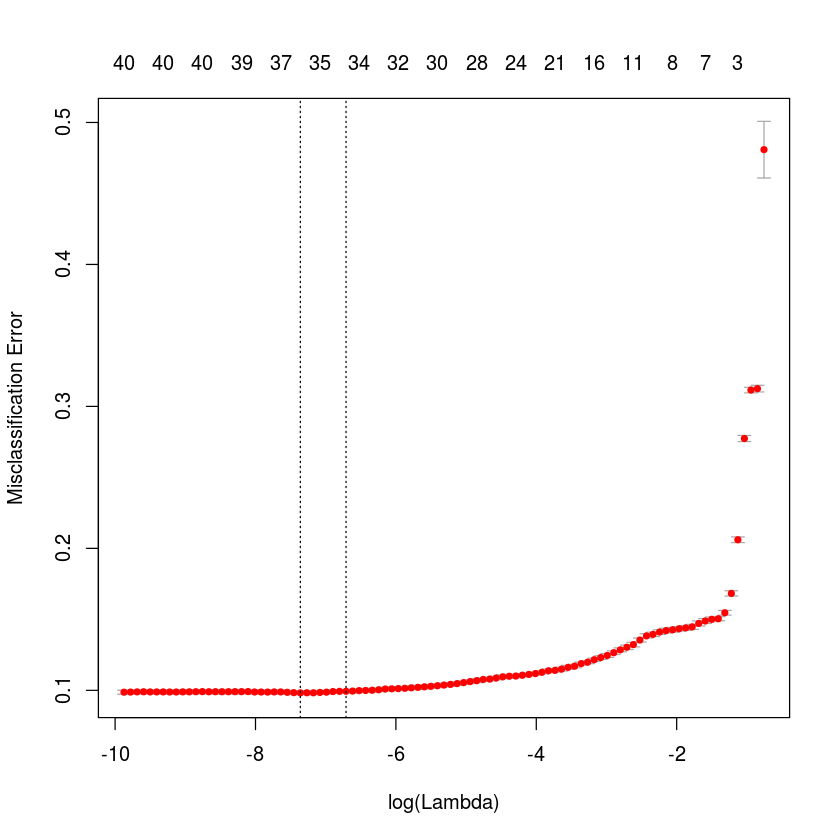

In [13]:
# Cross-validation curve
plot(weight.EN.fit)

# Estimated coefficients
coef(weight.EN.fit, s='lambda.1se')

# Confusion matrix
weight.EN.preds <- predict(weight.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='class')
weight.EN.CM <- confusionMatrix(as.factor(weight.EN.preds), test.data[, 1], positive=c('1'))
weight.EN.CM

# Sensitivity/specificity/precision/F1/accuracy
weight.EN.CM$byClass*100

# ROC curve
weight.EN.probs <- predict(weight.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='response')
weight.EN.roc <- roc(test.data[, 1], as.numeric(weight.EN.probs))

# Display area under the ROC curve
print('AUC')
weight.EN.roc$auc



### Classification Tree

Train a recursive partitioning tree using rpart.

In [14]:
t0 <- Sys.time()
weight.cart.fit <- rpart(Class ~.,
                         data=train.data,
                         weights = train.weights)
t1 <- Sys.time() - t0
t1

Time difference of 19.82227 secs

Show confusion matrix for test set, performance metrics, and plot the tree.

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 221816    246
         1  41487   3409
                                         
               Accuracy : 0.8437         
                 95% CI : (0.8423, 0.845)
    No Information Rate : 0.9863         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1181         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.93269        
            Specificity : 0.84244        
         Pos Pred Value : 0.07593        
         Neg Pred Value : 0.99889        
             Prevalence : 0.01369        
         Detection Rate : 0.01277        
   Detection Prevalence : 0.16818        
      Balanced Accuracy : 0.88757        
                                         
       'Positive' Class : 1              
                                         

Sensitivity          Specificity       Pos Pred Value 
           93.269494            84.243628             7.593104 
      Neg Pred Value            Precision               Recall 
           99.889220             7.593104            93.269494 
                  F1           Prevalence       Detection Rate 
           14.042965             1.369129             1.276980 
Detection Prevalence    Balanced Accuracy 
           16.817627            88.756561

[1] "AUC"


Area under the curve: 0.9353

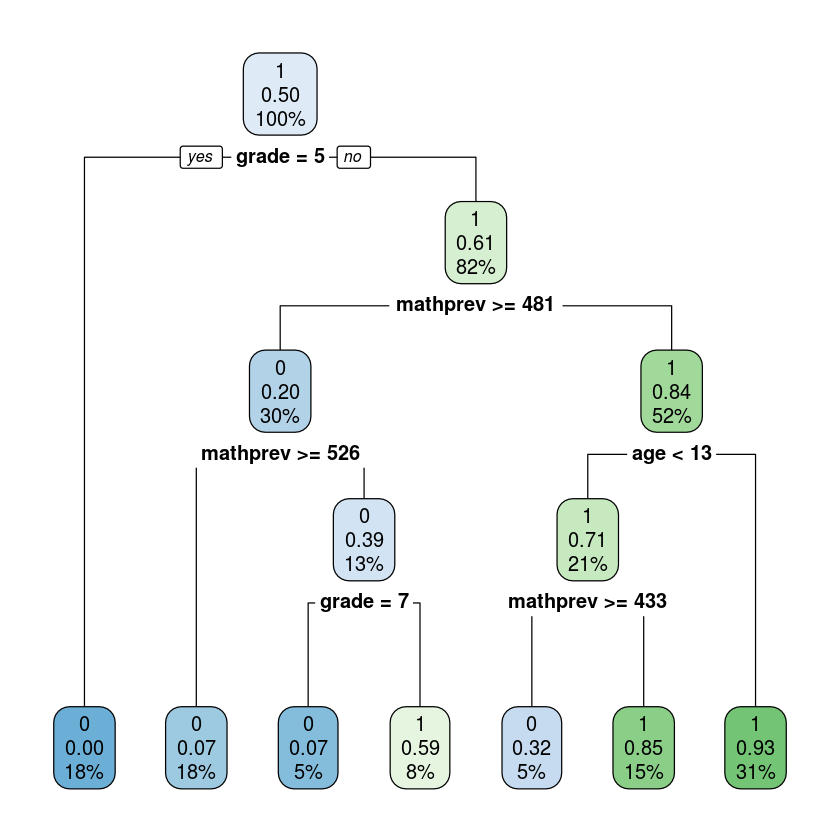

In [15]:
# Confusion matrix
weight.cart.preds <- predict(weight.cart.fit, newdata=test.data[, -1], type='class')
weight.cart.CM <- confusionMatrix(weight.cart.preds, test.data[, 1], positive="1")
weight.cart.CM
weight.cart.CM$byClass*100

# ROC curve
weight.oos.probs <- predict(weight.cart.fit, newdata=test.data[, -1])[, 2]
weight.roc <- roc(test.data[, 1], weight.oos.probs)
print('AUC')
weight.roc$auc


# Plot the tree
rpart.plot(weight.cart.fit,
           cex=1,
           fallen.leaves=T)


## SMOTE Classifiers

We balance the training set by generating a SMOTE sample using the out-of-the-box settings.

In [16]:
# Generate SMOTE sample
SMOTE.data <- SMOTE(Class ~., train.data)
dim(SMOTE.data)
summary(SMOTE.data)

# Turn into matrices
X <- model.matrix(Class ~., SMOTE.data)
y <- SMOTE.data$Class

[1] 51177    29

 Class     priv      grade          age        indig     mumschool mumhighed
 0:29244   0:28651   5:10379   Min.   : 9.20   0:45862   1: 4508   5:14396  
 1:21933   1:22526   7:17830   1st Qu.:12.20   1: 5315   2:11673   6: 7963  
                     9:22968   Median :13.27             3: 6641   7:12004  
                               Mean   :13.06             4:28355   8:16814  
                               3rd Qu.:14.36                                
                               Max.   :17.50                                
 mumoccup  dadschool dadhighed dadoccup  sameschool    readprev    
 1: 7769   1: 5674   5:18824   1: 9324   0:20934    Min.   : 12.5  
 2: 9557   2:14122   6: 6295   2:11472   1:30243    1st Qu.:413.0  
 3:11633   3: 6274   7:10916   3:12835              Median :462.2  
 4: 8576   4:25107   8:15142   4:12157              Mean   :470.0  
 8:13642                       8: 5389              3rd Qu.:523.5  
                                                    M

### Elastic Net (SMOTE)

Now run the elastic net and tree, but without class weights this time.

In [17]:

# Estimate the elastic net classifier
t0 <- Sys.time()
set.seed(2718)
SMOTE.EN.fit <- cv.glmnet(x=X,
                          y=y,
                          family="binomial",
                          alpha=0.5,
                          type.measure="class",
                          parallel=T)
Sys.time() - t0

Time difference of 27.07904 secs

Display coefficients, CV curve, confusion matrix, performance measures.

45 x 1 sparse Matrix of class "dgCMatrix"
                         1
(Intercept)   -2.682037953
(Intercept)    .          
priv1          0.146358336
grade7         5.135952102
grade9         5.614414022
age            1.234560497
indig1         1.505202198
mumschool2     .          
mumschool3    -0.020833639
mumschool4    -0.241761980
mumhighed6    -0.005211530
mumhighed7     .          
mumhighed8     0.025637464
mumoccup2      .          
mumoccup3     -0.143565409
mumoccup4     -0.020871095
mumoccup8      0.041484972
dadschool2    -0.102977443
dadschool3    -0.193741550
dadschool4    -0.261710734
dadhighed6     0.086292696
dadhighed7    -0.165594049
dadhighed8     0.077198225
dadoccup2     -0.169122659
dadoccup3      .          
dadoccup4      0.041472615
dadoccup8      0.362882802
sameschool1   -0.304396132
readprev      -0.010036066
mathprev      -0.025641563
girl1          0.131445710
met1          -0.421459001
provincial1    0.197528528
remote1        0.889223277
lbote1       

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 238591    500
         1  24712   3155
                                          
               Accuracy : 0.9056          
                 95% CI : (0.9044, 0.9067)
    No Information Rate : 0.9863          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1803          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.86320         
            Specificity : 0.90615         
         Pos Pred Value : 0.11322         
         Neg Pred Value : 0.99791         
             Prevalence : 0.01369         
         Detection Rate : 0.01182         
   Detection Prevalence : 0.10439         
      Balanced Accuracy : 0.88467         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           86.320109            90.614615            11.321635 
      Neg Pred Value            Precision               Recall 
           99.790875            11.321635            86.320109 
                  F1           Prevalence       Detection Rate 
           20.017765             1.369129             1.181834 
Detection Prevalence    Balanced Accuracy 
           10.438721            88.467362

[1] "AUC"


Area under the curve: 0.9541

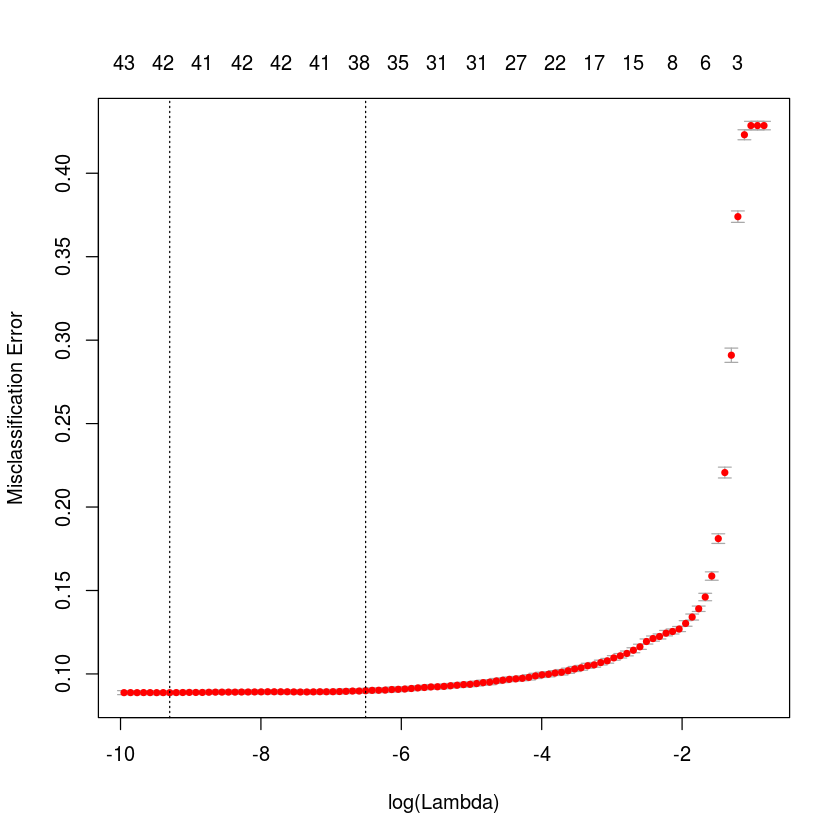

In [18]:
# Coefficients
coef(SMOTE.EN.fit, s='lambda.1se')

# Confusion matrix
SMOTE.EN.preds <- predict(SMOTE.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='class')
SMOTE.EN.CM <- confusionMatrix(as.factor(SMOTE.EN.preds), test.data[, 1], positive=c('1'))
SMOTE.EN.CM
SMOTE.EN.CM$byClass*100

# ROC curve
SMOTE.EN.probs <- predict(SMOTE.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='response')
SMOTE.EN.roc <- roc(test.data[, 1], as.numeric(SMOTE.EN.probs))

print('AUC')
SMOTE.EN.roc$auc

# CV curve
plot(SMOTE.EN.fit)


### Decision Tree (SMOTE)


In [19]:
t0 <- Sys.time()
SMOTE.cart.fit <- rpart(Class ~.,
                    data=SMOTE.data[, 1:29])
t1 <- Sys.time() - t0
t1


Time difference of 1.807312 secs

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 238231    641
         1  25072   3014
                                          
               Accuracy : 0.9037          
                 95% CI : (0.9026, 0.9048)
    No Information Rate : 0.9863          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1698          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.82462         
            Specificity : 0.90478         
         Pos Pred Value : 0.10731         
         Neg Pred Value : 0.99732         
             Prevalence : 0.01369         
         Detection Rate : 0.01129         
   Detection Prevalence : 0.10521         
      Balanced Accuracy : 0.86470         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           82.462380            90.477890            10.731325 
      Neg Pred Value            Precision               Recall 
           99.731655            10.731325            82.462380 
                  F1           Prevalence       Detection Rate 
           18.991210             1.369129             1.129017 
Detection Prevalence    Balanced Accuracy 
           10.520756            86.470135

[1] "AUC"


Area under the curve: 0.8921

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”

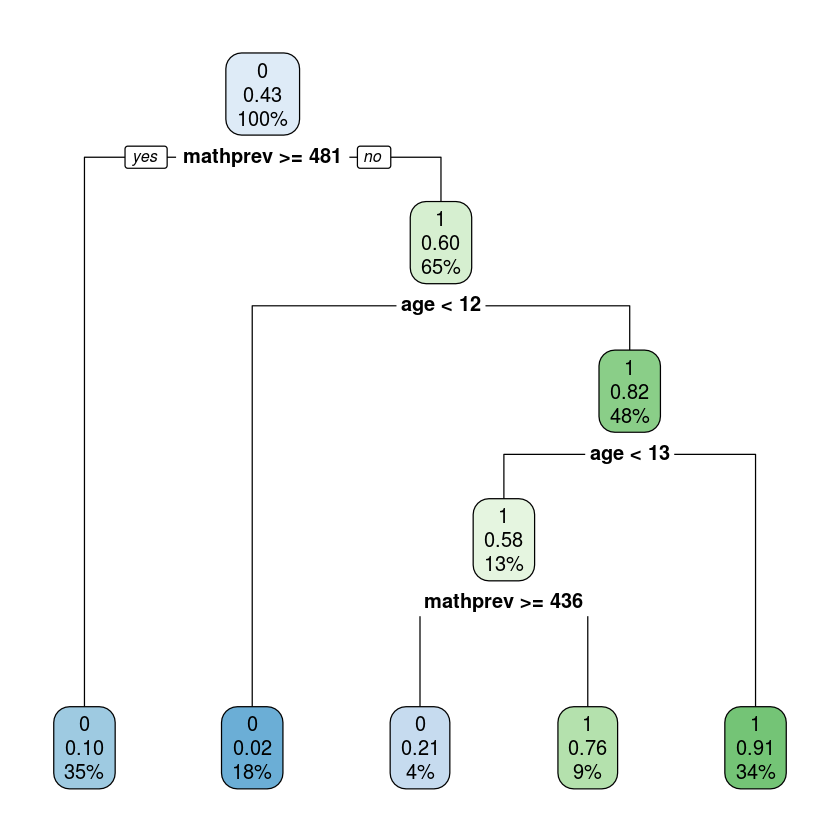

In [20]:
# Confusion Matrix
SMOTE.cart.preds <- predict(SMOTE.cart.fit, newdata=test.data[, -1], type='class')
SMOTE.cart.CM <- confusionMatrix(SMOTE.cart.preds, test.data[, 1], positive="1")
SMOTE.cart.CM
SMOTE.cart.CM$byClass*100

# ROC curve
SMOTE.cart.oos.probs <- predict(SMOTE.cart.fit, newdata=test.data[, -1])[, 2]
SMOTE.cart.roc <- roc(test.data[, 1], SMOTE.cart.oos.probs)
print("AUC")
SMOTE.cart.roc$auc

# Plot tree
rpart.plot(SMOTE.cart.fit,
           cex=1,
           fallen.leaves=T)


## Random Forest (SMOTE)

Now let's train a random forest on the SMOTE sample. Use an ensemble of 200 trees.



In [21]:
t0 <- Sys.time()
set.seed(2718)
rf.fit <- randomForest(x=X,
                       y=y,
                       ntree = 200)
Sys.time() - t0


Time difference of 55.77164 secs

png 
  2

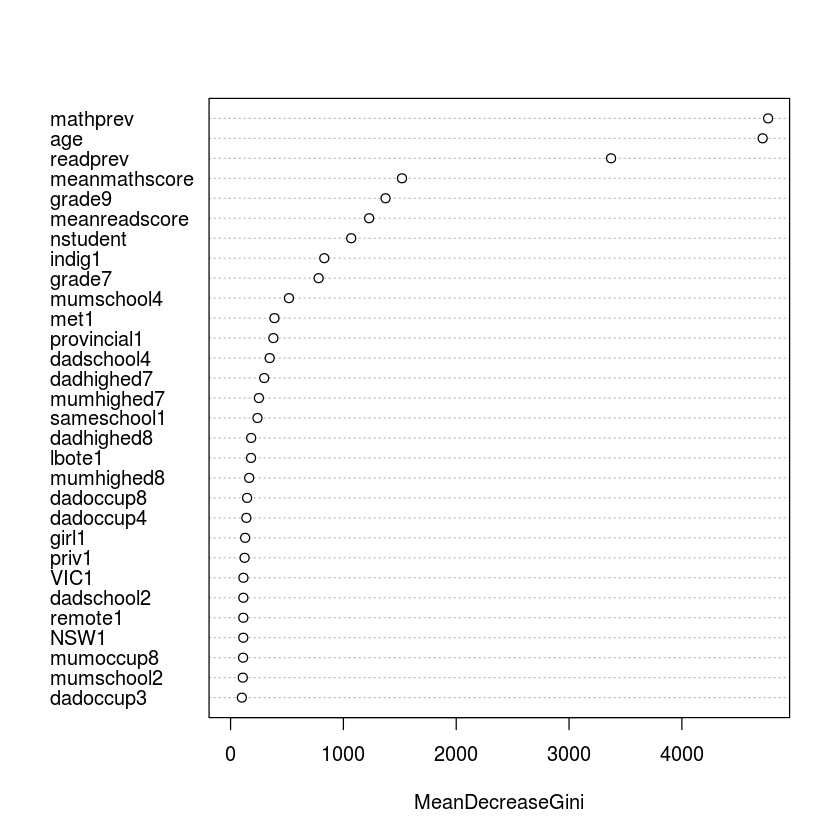

In [22]:
# Plot variable importance
setEPS()
postscript("RF_varimp_Num_G5.eps", fonts=c('serif'))
varImpPlot(rf.fit, type=2, main="")
dev.off()

varImpPlot(rf.fit, type=2, main="")

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 243352    616
         1  19951   3039
                                         
               Accuracy : 0.923          
                 95% CI : (0.9219, 0.924)
    No Information Rate : 0.9863         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.2094         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.83146        
            Specificity : 0.92423        
         Pos Pred Value : 0.13219        
         Neg Pred Value : 0.99748        
             Prevalence : 0.01369        
         Detection Rate : 0.01138        
   Detection Prevalence : 0.08612        
      Balanced Accuracy : 0.87785        
                                         
       'Positive' Class : 1              
                                         

Sensitivity          Specificity       Pos Pred Value 
           83.146375            92.422798            13.218791 
      Neg Pred Value            Precision               Recall 
           99.747508            13.218791            83.146375 
                  F1           Prevalence       Detection Rate 
           22.811034             1.369129             1.138381 
Detection Prevalence    Balanced Accuracy 
            8.611842            87.784586

[1] "AUC"


Area under the curve: 0.9549

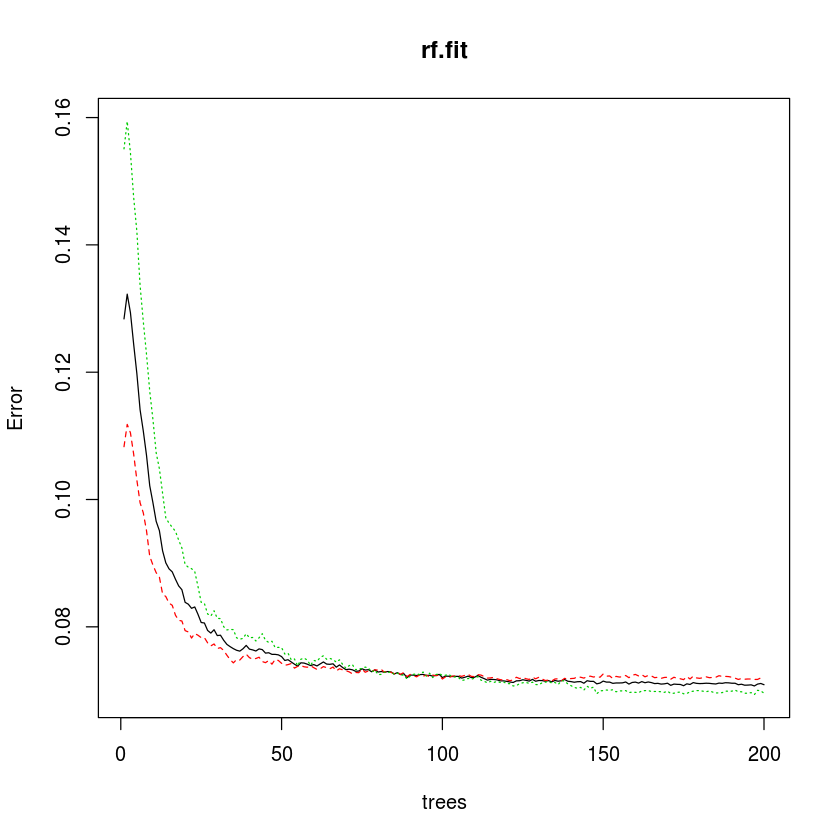

In [23]:
# Confusion matrix
rf.preds <- predict(rf.fit, newdata=model.matrix(Class ~., test.data), type='class')
rf.CM <- confusionMatrix(rf.preds, test.data[, 1], positive="1")
rf.CM
rf.CM$byClass*100

# ROC curve
SMOTE.rf.oos.probs <- predict(rf.fit, newdata=model.matrix(Class ~., test.data), type='prob')[, 2]
SMOTE.rf.roc <- roc(test.data[, 1], SMOTE.rf.oos.probs)
print("AUC")
SMOTE.rf.roc$auc

# Plot the random forest training curves
plot(rf.fit)


## ROC Curves

We've saved the individual ROC curves for each of the 5 classifiers. Let's plot them all together on the one graph. First get all the data together in a data frame for ggplot2.

In [24]:
weight.EN.roc.df <- data.frame(Sens=weight.EN.roc$sensitivities, Spec=weight.EN.roc$specificities, Classifier='Weighted EN')
weight.roc.df <- data.frame(Sens=weight.roc$sensitivities, Spec=weight.roc$specificities, Classifier='Weighted Tree')
SMOTE.EN.roc.df <- data.frame(Sens=SMOTE.EN.roc$sensitivities, Spec=SMOTE.EN.roc$specificities, Classifier='SMOTE EN')
SMOTE.cart.roc.df <- data.frame(Sens=SMOTE.cart.roc$sensitivities, Spec=SMOTE.cart.roc$specificities, Classifier='SMOTE Tree')
SMOTE.rf.roc.df <- data.frame(Sens=SMOTE.rf.roc$sensitivities, Spec=SMOTE.rf.roc$specificities, Classifier='SMOTE RF')


# For some reason the Elastic Net ROC curves have a huge number of data points.
# Down sample them in order to plot the ROC curve
ix <- sample(nrow(weight.EN.roc.df), 50, replace = F)
weight.EN.roc.df <- weight.EN.roc.df[ix, ]
ix <- sample(nrow(SMOTE.EN.roc.df), 50, replace = F)
SMOTE.EN.roc.df <- SMOTE.EN.roc.df[ix, ]

all.rocs <- rbind(weight.EN.roc.df,
                  weight.roc.df,
                  SMOTE.EN.roc.df,
                  SMOTE.cart.roc.df,
                  SMOTE.rf.roc.df)



Now plot the curves.

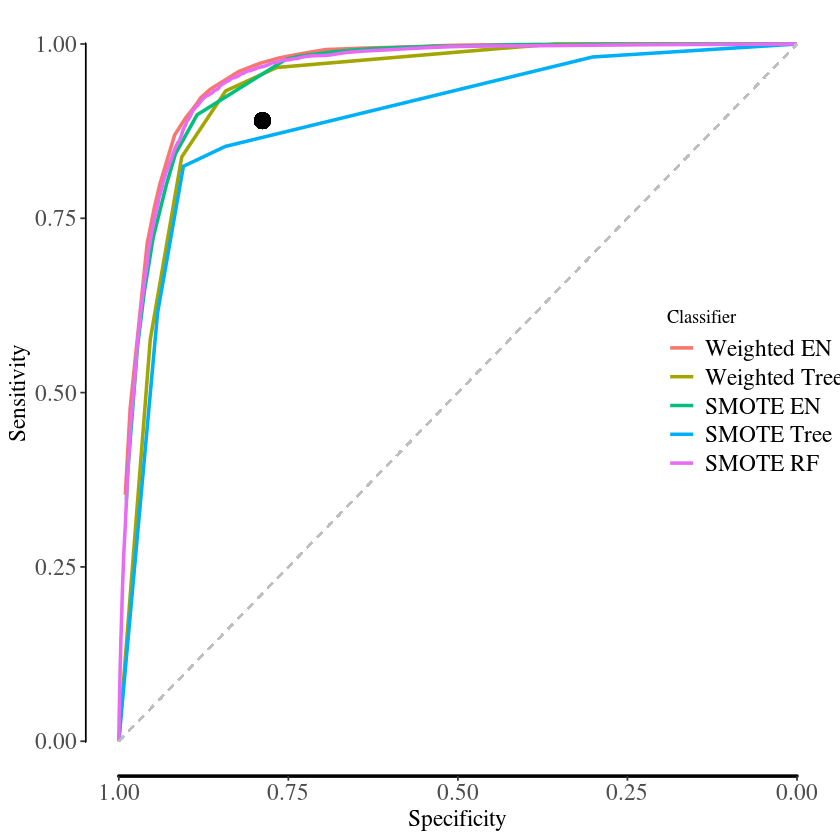

In [25]:
ROC2 <- ggplot(data=all.rocs, aes(x=Spec, y=Sens, color=Classifier)) +  
      geom_line(stat='identity', cex=1)+
      scale_x_reverse() + 
      geom_rangeframe(color='black', cex=1) + 
      theme_tufte() + 
      xlab('Specificity') + 
      ylab('Sensitivity') + 
      geom_segment(aes(x = 1, xend = 0, y = 0, yend =1), linetype='dashed', color='grey', size=0.5)+
      theme (axis.text.x = element_text(size=14),
         axis.text.y = element_text(size=14),
         axis.title = element_text(size=14),
         legend.text = element_text(size=14),
         legend.position = c(.9, .5))+
      geom_point(aes(x=naive.CM$byClass[1], y=naive.CM$byClass[2]), color='black', cex=4)
ROC2

## Cleaning Up

Let's put the relevant outputs into a clean form so that they can be copied into the paper. 

Start by saving our decision trees and ROC curve to disk in postscript format.


In [26]:
# Weighted tree
setEPS()
postscript("Num_Weighted_Tree.eps", width=23, height=10, pointsize=12)
rpart.plot(weight.cart.fit,
           cex=1.5,
           fallen.leaves=T)
dev.off()

# Smote tree
setEPS()
postscript("Num_Smote_Tree.eps", width=23, height=10, pointsize=12)
rpart.plot(SMOTE.cart.fit,
           cex=1.5,
           fallen.leaves=T)
dev.off()

setEPS()
postscript("ROC_Num.eps", fonts=c('serif'))
ROC2
dev.off()

png 
  2

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”

png 
  2

png 
  2

Make a LaTeX table with our elastic net coefficients.

In [27]:
library(xtable) # LaTeX tables

# Weighted EN
Cw <- coef(weight.EN.fit)

# Round the coefficients to 2SF.
Cw <- round(Cw[, 1], 2)

# SMOTE EN
Cs <- coef(SMOTE.EN.fit)
Cs <- round(Cs[, 1], 2)

temp <- data.frame(Weighted=Cw, SMOTE=Cs)

# Note that there are two instances of 'intercept'. 
# Remove the second.
temp <- temp[-2, ]

# Now load the coefficients for literacy (EN)
load('ElasticNetCoefs.Rda')

# Bind them together
EN <- cbind(EN, temp)

tab1 <- xtable(EN,
              align='ll|cccc',
              caption='Estimated coefficients for elastic net classifiers.',
              label='tab:CoefsEN')

# Export to .tex file
print(tab1, include.rownames=F)
write.table(print(tab1, include.rownames=F), 'CoefsEN.tex')



% latex table generated in R 3.4.0 by xtable 1.8-2 package
% Thu Aug 30 14:28:42 2018
\begin{table}[ht]
\centering
\begin{tabular}{l|cccc}
  \hline
Variable & Weighted & SMOTE & Weighted & SMOTE \\ 
  \hline
(Intercept) & 1.44 & -2.45 & 2.56 & -2.68 \\ 
  priv1 & -0.15 & 0.06 & -0.14 & 0.15 \\ 
  grade7 & 5.32 & 4.60 & 5.99 & 5.14 \\ 
  grade9 & 6.55 & 4.96 & 7.58 & 5.61 \\ 
  age & 0.88 & 1.22 & 0.83 & 1.23 \\ 
  indig1 & 0.17 & 1.41 & 0.26 & 1.51 \\ 
  mumschool2 & 0.00 & -0.03 & 0.02 & 0.00 \\ 
  mumschool3 & -0.01 & 0.00 & 0.00 & -0.02 \\ 
  mumschool4 & -0.15 & -0.25 & -0.08 & -0.24 \\ 
  mumhighed6 & 0.06 & 0.00 & 0.00 & -0.01 \\ 
  mumhighed7 & -0.15 & -0.12 & -0.16 & 0.00 \\ 
  mumhighed8 & 0.00 & 0.00 & 0.04 & 0.03 \\ 
  mumoccup2 & 0.00 & 0.00 & 0.00 & 0.00 \\ 
  mumoccup3 & -0.04 & -0.09 & -0.03 & -0.14 \\ 
  mumoccup4 & 0.00 & 0.00 & 0.00 & -0.02 \\ 
  mumoccup8 & 0.02 & 0.02 & 0.06 & 0.04 \\ 
  dadschool2 & 0.00 & -0.07 & 0.01 & -0.10 \\ 
  dadschool3 & 0.00 & -0.02 & -0.1

Finally, save the workspace, and we're all done.

In [28]:
save.image('numeracy_workspace.RData')
print('Finished.') 
Sys.time() - start.time

[1] "Finished."


Time difference of 11.95759 mins